In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

In [39]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

customers["SignupDate"] = pd.to_datetime(customers["SignupDate"])
transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"])

In [40]:
# Merge datasets
transactions_merged = transactions.merge(customers, on="CustomerID", how="left")

In [41]:
# Create aggregated features for each customer
customer_features = (
    transactions_merged.groupby("CustomerID")
    .agg(
        total_spent=("TotalValue", "sum"),
        total_transactions=("TransactionID", "count"),
        avg_quantity=("Quantity", "mean"),
        num_unique_products=("ProductID", "nunique"),
    )
    .reset_index()
)

In [42]:
# Merge with demographic information 
customer_features = customer_features.merge(
    pd.get_dummies(customers[["CustomerID", "Region"]], columns=["Region"]),
    on="CustomerID",
    how="left"
)

In [43]:
# Standardize the data
scaler = StandardScaler()
feature_cols = [col for col in customer_features.columns if col != "CustomerID"]
features_scaled = scaler.fit_transform(customer_features[feature_cols])

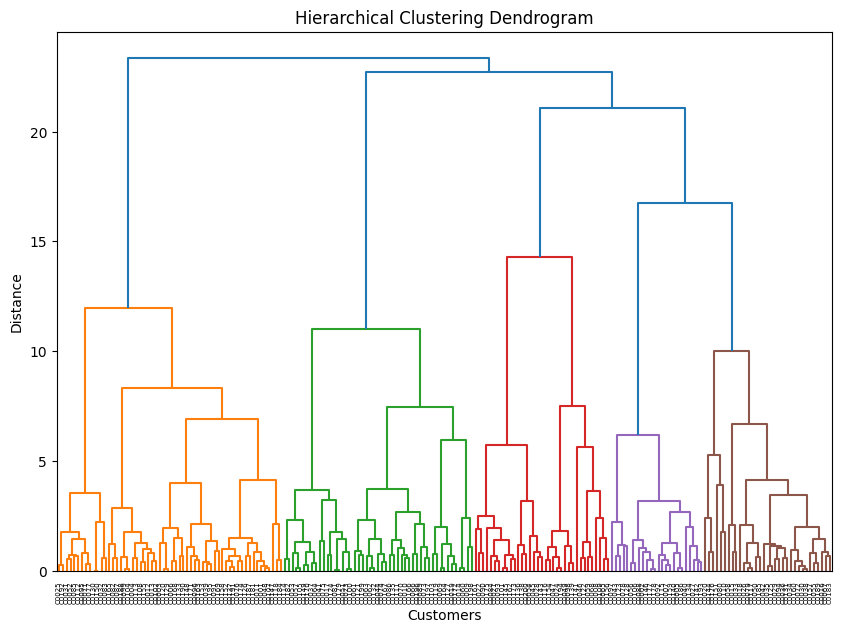

In [44]:
# Perform Hierarchical Clustering
linked = linkage(features_scaled, method="ward")

# Plot the dendrogram to decide the number of clusters
plt.figure(figsize=(10, 7))
dendrogram(linked, labels=customer_features["CustomerID"].values, orientation="top")
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Distance")
plt.show()

In [45]:
# Apply Agglomerative Clustering
n_clusters = 5  # Select the number of clusters based on dendrogram
agg_cluster = AgglomerativeClustering(n_clusters=n_clusters)
customer_features["Cluster"] = agg_cluster.fit_predict(features_scaled)

# Calculate Davies-Bouldin Index (DB Index)
db_index = davies_bouldin_score(features_scaled, customer_features["Cluster"])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 1.0970134860488643


C:\Users\kaniy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kaniy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kaniy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kaniy\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length

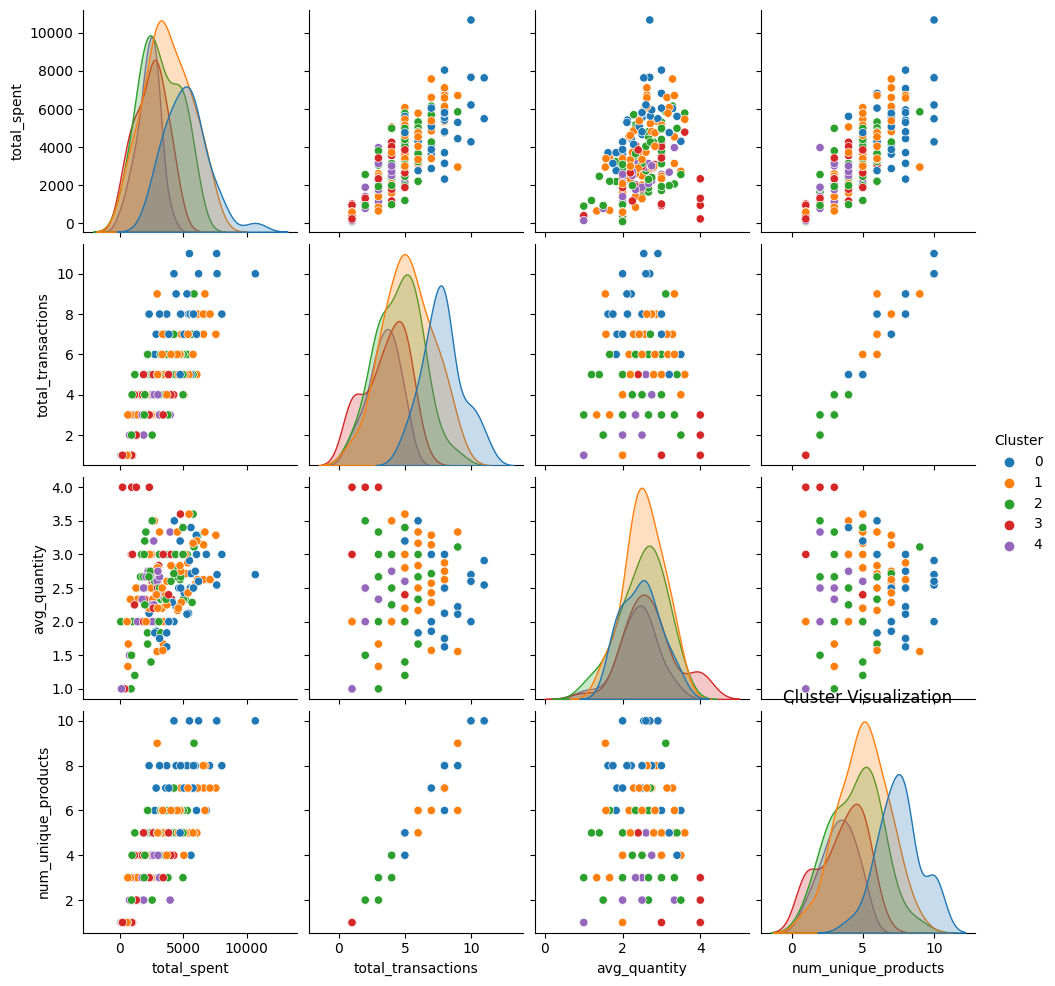

In [48]:
# Visualize clusters using a pairplot
sns.pairplot(
    customer_features,
    vars=["total_spent", "total_transactions", "avg_quantity", "num_unique_products"],
    hue="Cluster",
    palette="tab10",
)
plt.title("Cluster Visualization")
plt.show()

In [49]:
# Save clustering results to a CSV file
customer_features.to_csv("Customer_Clusters_Agglomerative.csv", index=False)
print("Clustering results saved to 'Customer_Clusters_Agglomerative.csv'")


Clustering results saved to 'Customer_Clusters_Agglomerative.csv'
